## License 

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

# Lecture 1: EBM Example

#### Python imports and inits

In [1]:
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np                                                                                             
import pandas as pd                                               
import time                                             

#### Global hyperpameters

In [2]:
SEED = 12345   # global random seed for better reproducibility
np.random.seed(SEED)

#### Start global timer

In [3]:
big_tic = time.time()

## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input features: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The steps below build several models to predict `DEFAULT_NEXT_MONTH` using payment, billing, and credit limit information in the UCI credit card default data.

#### Import data and reformat

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
Notice that demographic features are not used as model inputs.

In [5]:
# assign target and inputs for models
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y_name =', y_name)
print('x_names =', x_names)

y_name = DEFAULT_NEXT_MONTH
x_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics

In [6]:
data[x_names + [y_name]].describe() 

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Train Explainable Boosting Machine

#### Split data into training and validation partitions

In [7]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# convert to more standard scikit learn partitions
X_train = train[x_names]
X_valid = valid[x_names]
y_train = train[y_name]
y_valid = train[y_name]

Train data rows = 20946, columns = 25
Validation data rows = 9054, columns = 25


#### Train EBM

In [8]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(X_train, y_train)  

ExplainableBoostingClassifier(feature_names=['LIMIT_BAL', 'PAY_0', 'PAY_2',
                                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                             'BILL_AMT1', 'BILL_AMT2',
                                             'BILL_AMT3', 'BILL_AMT4',
                                             'BILL_AMT5', 'BILL_AMT6',
                                             'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                             'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                                             'PAY_0 x PAY_2', 'PAY_0 x PAY_3',
                                             'PAY_0 x BILL_AMT1',
                                             'PAY_0 x PAY_4',
                                             'PAY_0 x PAY_AMT2',
                                             'PAY_0 x PAY_AMT3',
                                             'LIMIT_BAL x BI...
                                             'continuous', 'continu

#### Show EBM feature plots - uncomment when running live for interactive output

In [9]:
#ebm_global = ebm.explain_global(name='EBM')
#show(ebm_global)

#### Extract static values for explanatory content that can be rendered with static plots

In [10]:
################################################################################
#                                                                              #   
# Dealing with EBM internals is easier in more recent versions of interpret.   #
# See, e.g., https://interpret.ml/docs/ebm-internals-regression.html           #
#                                                                              #  
################################################################################

# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
ebm_contribs = ebm.explain_local(X_valid)
names = ebm_contribs._internal_obj['specific'][0]['names']
ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, X_valid.shape[0]):
    row_df = pd.DataFrame(np.array(ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 29), columns=names)
    ebm_contribs_df = ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 4.35 s.


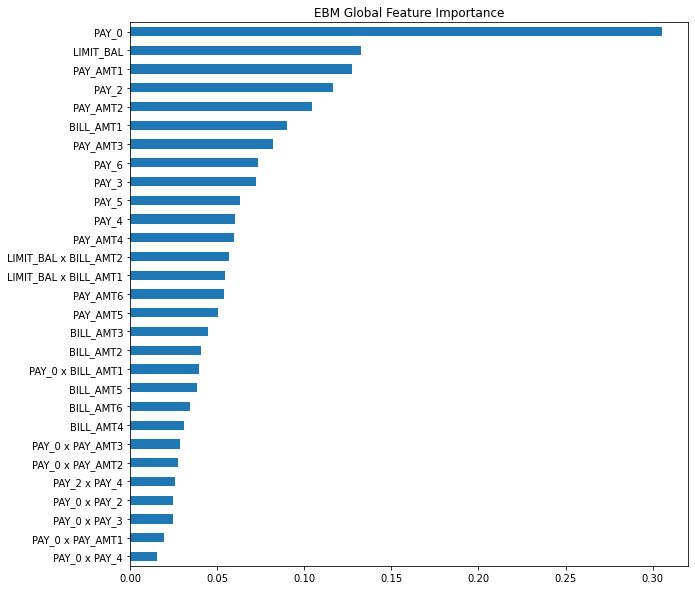

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
_ = np.abs(ebm_contribs_df).mean().sort_values().plot(kind='barh', ax=ax, title='EBM Global Feature Importance')

#### Utility function to manually plot partial dependence

In [12]:
def par_dep(x_name, valid, model, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Calculate partial dependence

In [13]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    pd_dict[name] = par_dep(name, X_valid, ebm)
    
print('Done.')

# end local timer
ebm_toc = time.time() - ebm_tic
print('Partial dependence calculated in %.2f s.' % (ebm_toc))

Calculating partial dependence for LIMIT_BAL ...
Calculating partial dependence for PAY_0 ...
Calculating partial dependence for PAY_2 ...
Calculating partial dependence for PAY_3 ...
Calculating partial dependence for PAY_4 ...
Calculating partial dependence for PAY_5 ...
Calculating partial dependence for PAY_6 ...
Calculating partial dependence for BILL_AMT1 ...
Calculating partial dependence for BILL_AMT2 ...
Calculating partial dependence for BILL_AMT3 ...
Calculating partial dependence for BILL_AMT4 ...
Calculating partial dependence for BILL_AMT5 ...
Calculating partial dependence for BILL_AMT6 ...
Calculating partial dependence for PAY_AMT1 ...
Calculating partial dependence for PAY_AMT2 ...
Calculating partial dependence for PAY_AMT3 ...
Calculating partial dependence for PAY_AMT4 ...
Calculating partial dependence for PAY_AMT5 ...
Calculating partial dependence for PAY_AMT6 ...
Done.
Partial dependence calculated in 10.85 s.


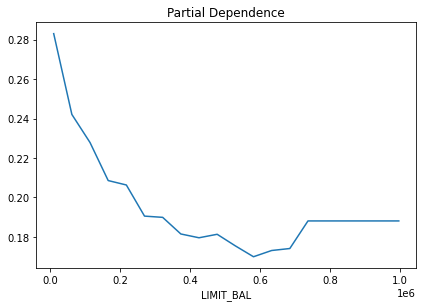

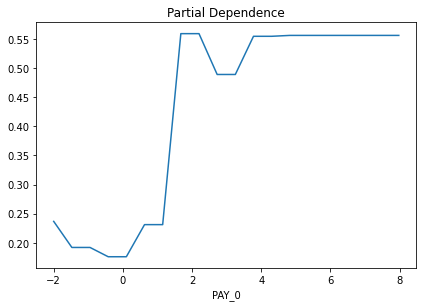

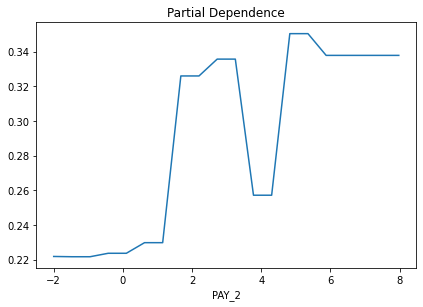

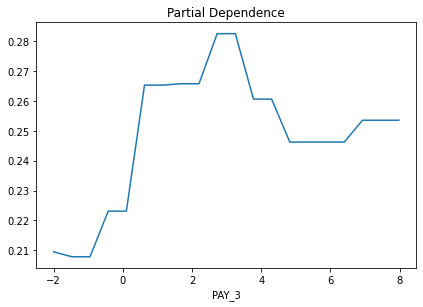

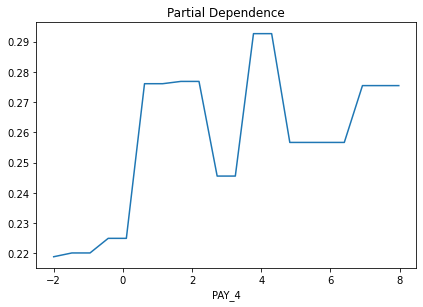

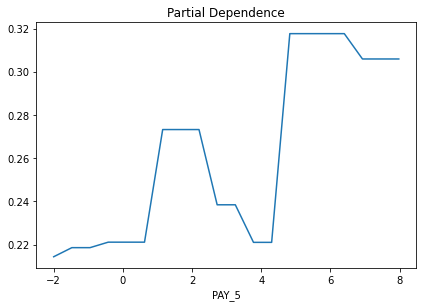

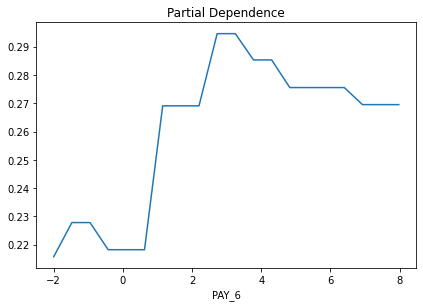

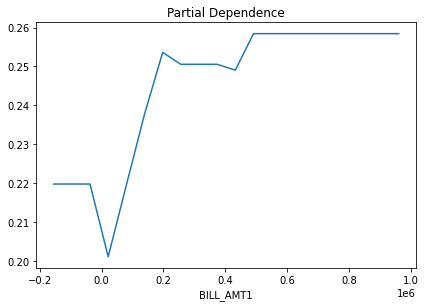

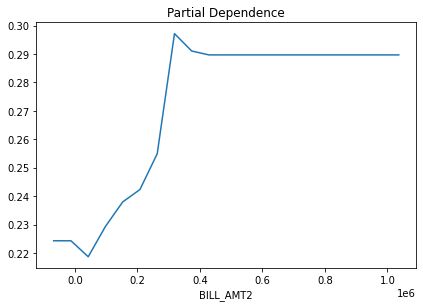

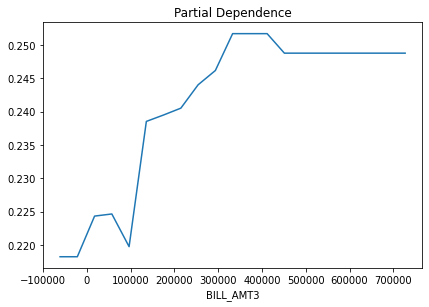

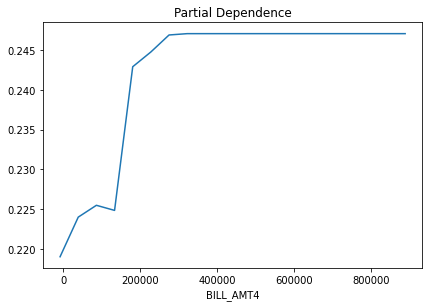

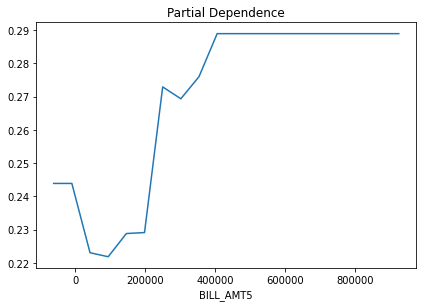

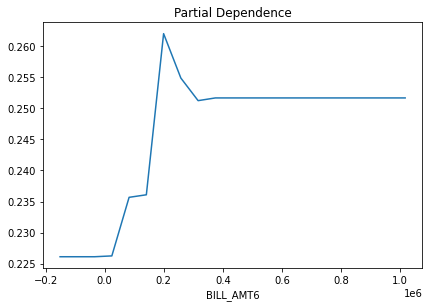

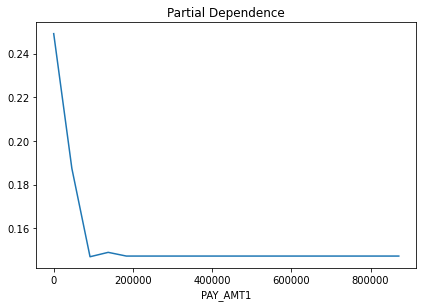

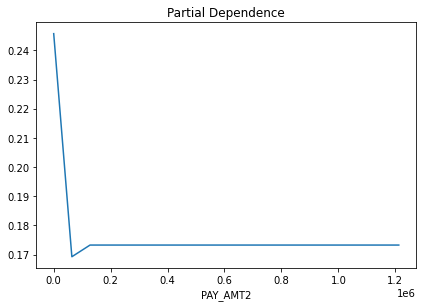

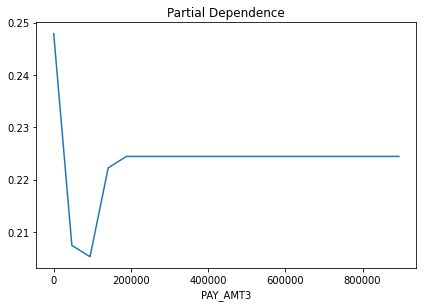

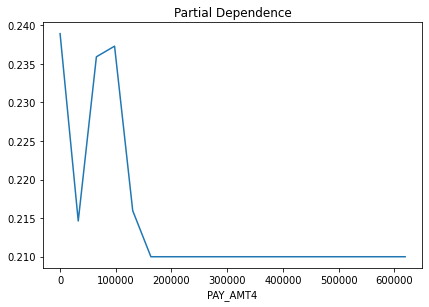

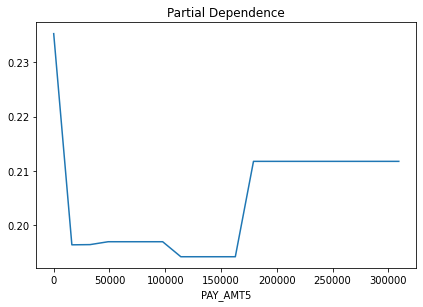

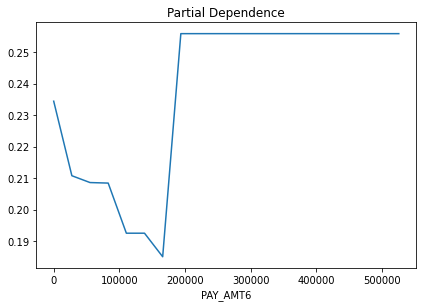

In [14]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init plot
    fig, ax = plt.subplots()
    plt.tight_layout()

    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='partial_dependence', ax=ax, title='Partial Dependence',
                      legend=False)
    ax.set_xlabel(name)


#### Display partial dependence

#### End global timer

In [15]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 18.61 s.
